In [161]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp
from jax import grad
from jax import random

In [162]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, \
random_state=2)

X_train = X_train.T
X_test = X_test.T

In [163]:
print('X_train shape: ', np.shape(X_train))
print('Y_train shape: ', np.shape(y_train))
print('X_test shape: ', np.shape(X_test))
print('y_test shape: ', np.shape(y_test))

X_train shape:  (4, 120)
Y_train shape:  (120,)
X_test shape:  (4, 30)
y_test shape:  (30,)


In [164]:
def softmax_prob(W, inputs):
    # output is datalen-by-C
    # inputs is (dim)-by-datalen
    # W is C-by-(dim+1)
    # Make sure all numerical operations are from JAX, so 'jnp', not 'np'
    datalen = jnp.shape(inputs)[1]
    c = len(W)# number of classes, C, each class has a bias
    inputs = jnp.concatenate((jnp.ones((1,datalen)), inputs), axis=0)
    score = jnp.dot(W,inputs)
    large = jnp.max(score, axis=0)
    large_offset = jnp.dot(np.ones((c, datalen)),jnp.diag(large))
    expscore = jnp.exp(score - large_offset)
    norm_factor = jnp.diag(1/jnp.sum(expscore, axis=0))
    return jnp.dot(expscore, norm_factor).T

In [165]:
def softmax_xentropy(Wb, inputs, targets, num_classes):
    epsilon = 1e-8
    ys = get_one_hot(targets, num_classes)
    logprobs = -jnp.log(softmax_prob(Wb, inputs)+epsilon)
    return jnp.mean(ys*logprobs)

In [166]:
def get_one_hot(targets, num_classes):
    res = jnp.eye(num_classes)[jnp.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[num_classes])

In [167]:
def grad_descent(Wb, inputs, targets, num_classes, lrate, nsteps):
    W1 = Wb
    Whist = [W1]
    losshist = [softmax_xentropy(W1,inputs, targets, num_classes )]
    eta = lrate # learning rate
    for i in range(nsteps):
        gWb = grad(softmax_xentropy, (0))(W1, inputs, targets, num_classes)
        W1 = W1 - eta*gWb
        if (i%5 ==0):
            Whist.append(W1)
            losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    Whist.append(W1)
    losshist.append(softmax_xentropy(W1, inputs, targets, num_classes))
    return W1, Whist, losshist

In [170]:
X_train_shape = np.shape(X_train)
W = np.random.rand(len(np.unique(y_train)), X_train_shape[0]+1)

print('X_train_shape: ', X_train_shape)
print('Weight shape: ', np.shape(W) )
print('y_train', np.shape(y_train))


X_train_shape:  (4, 120)
Weight shape:  (3, 5)
y_train (120,)


In [169]:

W1, Whist, losshist = grad_descent(W, X_train, y_train, 3, 0.1, 400)

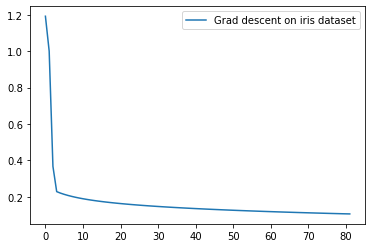

In [10]:
plt.plot(np.arange(len(losshist)), losshist, label='Grad descent on iris dataset')
plt.legend()

# Now to test xentropy on test set 

In [11]:
print(' train entropy: ', softmax_xentropy(W1, X_train, y_train, 3))
print(' test entropy: ', softmax_xentropy(W1, X_test, y_test, 3))

 train entropy:  0.1059579
 test entropy:  0.09449384


This method actualy performs better on the test set than the training set. 

# Lets try cross validation
1. create a function that splits the data into N training and test sets
2. Train them 
3. calculate cross entropy 
4. add all the xentropy together and average 

In [179]:

num_classes = 3

In [186]:
from sklearn.model_selection import KFold

X = iris.data
y = iris.target

def get_cross_entropy(X, y, folds, steps):
    kf = KFold(n_splits=10, shuffle=True, random_state=None)
    all_entropy = np.array([])
    W = np.random.rand(3, 5)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        W1, Whist, losshist = grad_descent(W, X_train.T, y_train, 3, 0.1, steps)
        ent = softmax_xentropy(W1, X_test.T, y_test, 3)
        all_entropy = np.append(all_entropy, ent)
    return all_entropy
    

    
Xentropy = get_cross_entropy(X, y, 10, 200)  
    
    


[0.1231004  0.15523604 0.14825834 0.11274483 0.16477706 0.12483627
 0.11901793 0.1379946  0.1821124  0.14137682]


In [207]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score

X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0).fit(X, y)


scores = cross_val_score(clf, X, y, cv=10, scoring='neg_log_loss')
print('our model mean log loss', np.mean(Xentropy))
print('scikit learns mean log loss', np.mean(abs(scores)))

print('It looks like ours is much better')


our model mean log loss 0.1409454680979252
scikit learns mean log loss 0.3205954991218555
It looks like ours is much better


/Users/olivergrainge/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/olivergrainge/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/olivergrainge/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/olivergrainge/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warni

In [212]:
import matplotlib.pyplot as plt
base = np.arange(3)+1
base

array([1, 2, 3])

In [216]:
W1, Whist, losshist = grad_descent(W, X.T, y, 3, 0.1, 400)       

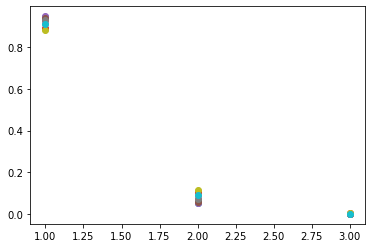

In [231]:
for i in range(10):
    arr = softmax_prob(W1, X[i:i+1].T)
    plt.scatter(base, arr[1])